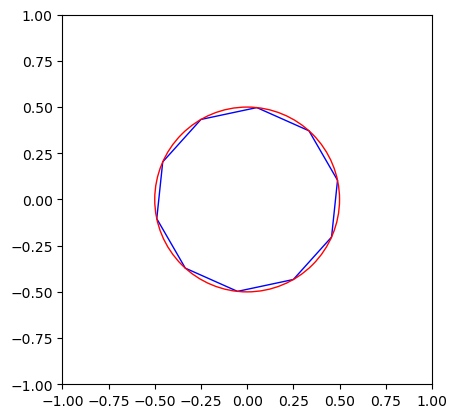

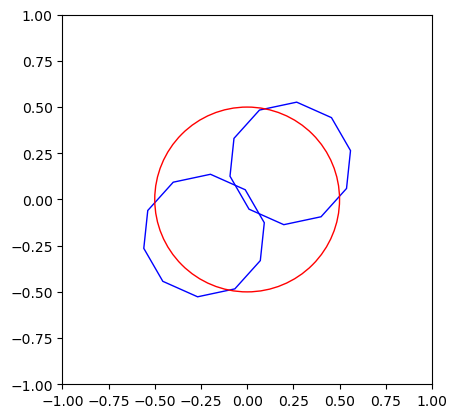

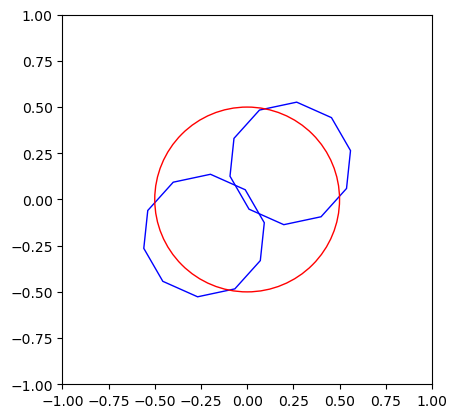

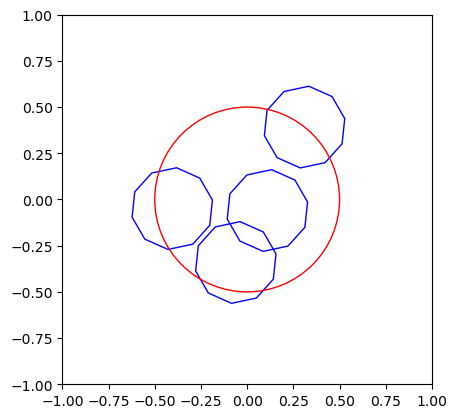

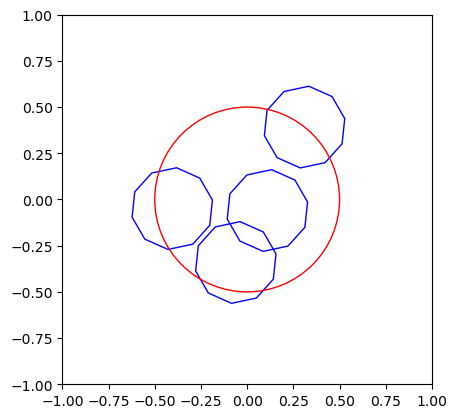

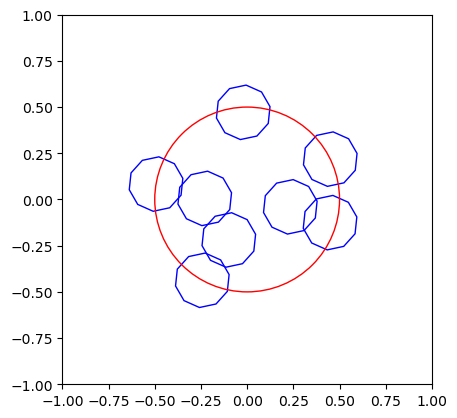

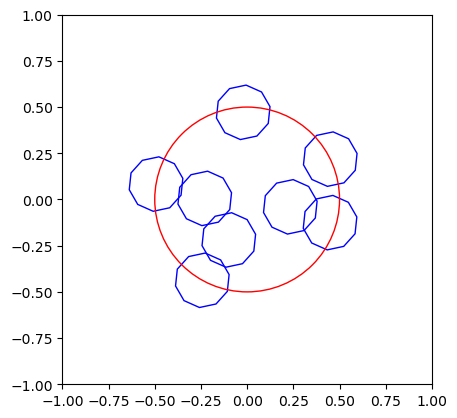

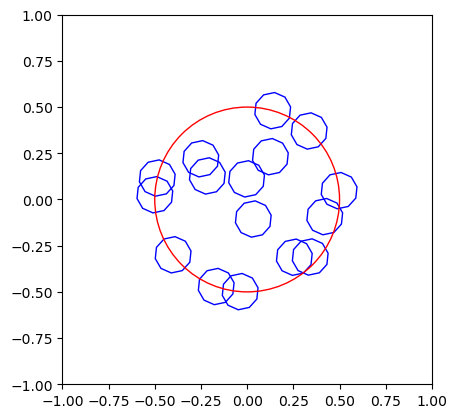

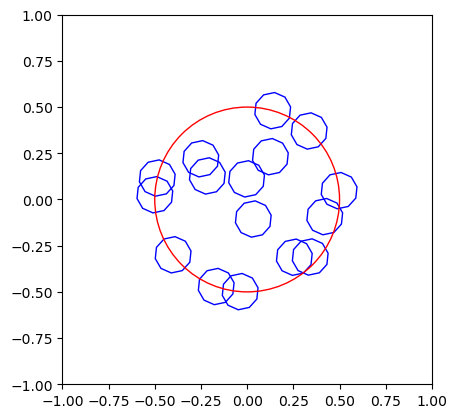

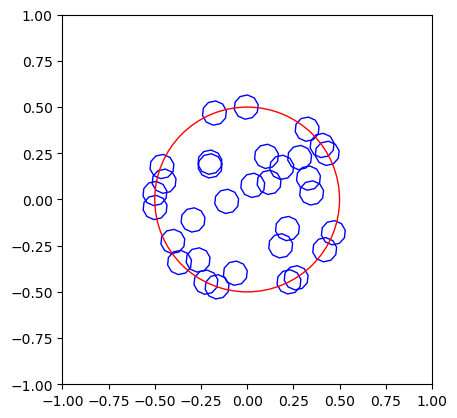

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

# Parameters
num_steps = 10
initial_cells = 1
division_rate = 1
adhesion_force = 0.5
initial_rest_length = 0.5
spring_constant = 1.0
radius = initial_rest_length  # Boundary size set to the size of the first cell


# Initialize cells (each cell is represented by the vertices of a hexagon)
def create_hexagon(center, size=initial_rest_length):
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]
    return center + size * np.array([np.cos(angles), np.sin(angles)]).T


cells = [{
    'vertices': create_hexagon(np.array([0.0, 0.0]), initial_rest_length),
    'center': np.array([0.0, 0.0]),
    'cycle': 0.0,
    'size': initial_rest_length
}]


def divide(cell):
    # Simulate cell division by creating two new cells with half the size of the parent cell
    new_size = cell['size'] * 2 / 3.0
    offset = np.random.uniform(-0.35, 0.35, 2)
    new_center_1 = cell['center'] + offset
    new_center_2 = cell['center'] - offset

    new_cell_1 = {
        'vertices': create_hexagon(new_center_1, new_size),
        'center': new_center_1,
        'cycle': 0.0,
        'size': new_size
    }
    new_cell_2 = {
        'vertices': create_hexagon(new_center_2, new_size),
        'center': new_center_2,
        'cycle': 0.0,
        'size': new_size
    }
    return [new_cell_1, new_cell_2]


def apply_adhesion(cells):
    # Apply adhesion forces to cells
    for i, cell in enumerate(cells):
        for j, other_cell in enumerate(cells):
            if i != j:
                distance = np.linalg.norm(cell['center'] -
                                          other_cell['center'])
                if distance < 1.0:
                    force = adhesion_force * (1.0 - distance)
                    direction = (cell['center'] -
                                 other_cell['center']) / distance
                    cell['center'] += force * direction
                    other_cell['center'] -= force * direction


def apply_elasticity(cell):
    # Apply elastic forces to cell vertices
    for i in range(len(cell['vertices'])):
        for j in range(i + 1, len(cell['vertices'])):
            distance = np.linalg.norm(cell['vertices'][i] -
                                      cell['vertices'][j])
            rest_length = cell['size']
            if distance > rest_length:
                force = spring_constant * (distance - rest_length)
                direction = (cell['vertices'][i] -
                             cell['vertices'][j]) / distance
                cell['vertices'][i] -= force * direction
                cell['vertices'][j] += force * direction


def apply_circular_constraint(cell, radius):
    # Ensure cell centers stay within the circular boundary
    distance_from_center = np.linalg.norm(cell['center'])
    if distance_from_center > radius:
        cell['center'] = (cell['center'] / distance_from_center) * radius
    # Ensure vertices stay within the circular boundary
    for i in range(len(cell['vertices'])):
        distance_from_center = np.linalg.norm(cell['vertices'][i])
        if distance_from_center > radius:
            cell['vertices'][i] = (cell['vertices'][i] /
                                   distance_from_center) * radius


# Simulation loop
for step in range(num_steps):
    new_cells = []
    cells_to_remove = []
    for cell in cells:
        if cell['cycle'] >= 1.0 / division_rate:
            new_cells.extend(divide(cell))
            cells_to_remove.append(cell['center'])
        else:
            cell['cycle'] += 1.0

    # Remove the divided cells
    cells = [
        cell for cell in cells if cell['center'].tolist() not in
        [c.tolist() for c in cells_to_remove]
    ]
    cells.extend(new_cells)

    # apply_adhesion(cells)

    # Apply elasticity and circular constraint to all cells
    for cell in cells:
        apply_elasticity(cell)
        apply_circular_constraint(cell, radius)

    # Visualization (hexagons)
    plt.clf()
    ax = plt.gca()
    for cell in cells:
        hexagon = RegularPolygon(cell['center'],
                                 numVertices=10,
                                 radius=cell['size'],
                                 orientation=np.pi / 6,
                                 facecolor='none',
                                 edgecolor='b')
        ax.add_patch(hexagon)

    plt.xlim(-radius * 2, radius * 2)
    plt.ylim(-radius * 2, radius * 2)
    circle = plt.Circle((0, 0), radius, color='r', fill=False)
    ax.add_artist(circle)
    ax.set_aspect('equal', 'box')
    plt.pause(0.1)

plt.show()


array([-0.11971996, -0.08410224])